# Creating a Model
----

In this notebook we will create our first Neural Net, a very simple one and we'll have it make some un-educated predictions. The predictions will be in-educated because we won't train the NN until later notebooks, but having it make predictions will show the in and output of Models in general.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.


## Preparation

Before creating features, we will have to import a couple of packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp

from typing import Tuple

And we define the **file** we will read from. For now, we'll use the same example as in the previous notebooks. It still very much looks like it did before

In [2]:
file = './data/intro_card.csv'

In [3]:
!cat $file

Date,Amount,Card,Merchant,MCC,Country,Fraud
20200101,1.0,CARD-1,MRC-1,0001,DE,0
20200102,2.0,CARD-2,MRC-2,0002,GB,0
20200103,3.0,CARD-1,MRC-3,0003,DE,1
20200104,4.0,CARD-1,MRC-3,0003,FR,0
20200104,5.0,CARD-2,MRC-2,0002,GB,0
20200106,6.0,CARD-2,MRC-4,,DE,0

## Setting up the features.

We'll begin with the typical steps, by setting up the features and making a numpy instance out of them. As base, we'll make a TensorDefinition containing the OneHot encoded 'MCC' and 'Country' features, one for the 'Scaled Amount' and one for the 'Fraud' label.

In [4]:
amount   = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
mcc      = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country  = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud    = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_oh, td_amount, td_label), file, inference=False)

2023-04-02 12:05:52.486 eng1n3.common.engine           INFO     Start Engine...
2023-04-02 12:05:52.487 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-02 12:05:52.488 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-02 12:05:52.489 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/intro_card.csv
2023-04-02 12:05:52.500 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-02 12:05:52.501 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


In [5]:
ti

TensorInstance with shapes: ((6, 7), (6, 1), (6, 1))

### Splitting 
(For giggles with a dataset this small)

In [6]:
train, val, test = ti.split_sequential(2,1)
train, val, test

(TensorInstance with shapes: ((3, 7), (3, 1), (3, 1)),
 TensorInstance with shapes: ((2, 7), (2, 1), (2, 1)),
 TensorInstance with shapes: ((1, 7), (1, 1), (1, 1)))

### DataSet

Next Thing we do is create a `Torch DataSet`. A DataSet is a 'Torch' object that can convert our sample data into Tensors. Tensors are x-dimensional spaces in which we hold our feature and they will be the input to our models. After we created a DataSet, we can access individual items of the data-set, i.e. specific samples. They now no longer hold Numpy arrays, but Tensors. (No worries, Numpy and Torch can share memory, we're not allocating everything twice)

In [7]:
# Creating DataSets from our NumpyInstance
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

Because our `TensorInstanceNumpy` contained 3 arrays, each sample we draw from the DataSet also contains 3 tensors. Here we see the 1st sample. 
- The first tensor is the **OneHot** encoded County and MCC. It has a size of 7 and type float32. (Note they were int8 in the Numpy array)
- The second tensor is the **Amount**.
- The last tensor is the **Fraud** label.

In [8]:
train_ds[0], train_ds[0][0].shape, train_ds[0][0].dtype

((tensor([1., 0., 0., 0., 1., 0., 0.]), tensor([1.]), tensor([0.])),
 torch.Size([7]),
 torch.float32)

## First Model

We create a model in the typical PyTorch manner, by creating a new 'nn.Module' class. The `m0d3l` package has a set of pre-prepared models that know how to interpret the input and create a specific output. In this case we will create a new class that inherits from the `BinaryClassifier` m0d3l. A binary classifier, performs a classification task with a '0' or '1' target.

We only need to worry about creating a layer that maps the input of the **Heads** to a specific **Output**.

The 'Heads' are the first layer, they need to match the input `TensorInstance`. In our example we had 3 lists of which two (the OneHot and Amount) contain the input data and the third list is the labels.

In this first example we will build an extremely simple model that consists of one linear layer only. During the forward pass, we just concatenate the heads, (that way we get a single tensor), run it through a **linear layer** and apply a **sigmoid** activation. 

The *input* to the linear layer is 8 (7 OneHot + 1 Amount Feature), the output is 1. 

The *output* of the linear layer is a sort of *'logits'*, after the sigmoid it becomes a number between 0 and 1, which we can, a bit hand-wavy, interpret as a **'probability'**. We have only one label but, still wrap it in a list. For consistency we always return a **Tuple of Tensors**, may seem strange now, but we will have models that make multiple predictions in one go.


In [9]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(FirstModel, self).__init__(tensor_instance)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # One Linear Layer that maps the output of the heads, size 11 to size 1.
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor,...]:
        # Forward through the heads an concatenate
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        # Forward through linear layer
        o = self.l1(o)
        # Forward through tail
        o = self.tail(o)
        # Return single item Tuple
        return (o,)

#Create a 'FirstModel' instance
model = FirstModel(train)
model

FirstModel(
  Number of parameters : 9. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Features_OH, lc=Binary)
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=8, out_features=1, bias=True)
  (tail): Sigmoid()
)

Once the model is created we can run an example through. We can call the model on a specific entry of the DataSet. But we can't just feed all the Numpy arrays in the list, we can only give it the input data, the **x-es**, not the labels, the **y'**. The `get_x` method of the model know which Tensors are in input and extracts those. Let's run the 1st sample of the training set through the model.

Calling model(*SOME_TENSORS*) will, via some PyTorch internals, end-up calling the *forward* method we defined in the model.

We get a result that should correspond to the probability of this sample is a fraud. But obviously at this point in time that is not going to make a lot of sense, the model has not been trained yet.

In [10]:
# Need ot unsqueeze, getting one item from a data-set looses the batch-dimension.
inp = tuple(t.unsqueeze(dim=0) for t in model.get_x(train_ds[0]))
model(inp)[0].item()

0.4686119854450226

### Embedding

Looking at the previous example one might wonder why we have the headers. It might look simpler to just concatenate the input and feed it as one string.

Besides being more interesting for the storage, there is an other important reason. In the f3atur3s notebooks we saw that we can create feature of type 'Categorical', like for instance the FeatureIndex and FeatureBin. Their output is an integer number, and integer numbers can not be fed as-is to Neural Nets, Neural Nets insist on working with 'Float' numbers.

In such cases Neural Nets typical use **Embeddings**. We're not going to go into detail on Embeddings here, that might be a topic for a specific notebooks. But as sneak preview, think of an embedding as a multi-dimensional space in which the network can move the values around. The Neural Net can place them so that their relative distances across specific axis express some sort of meaning. It might for instance cluster similar items in a specific area of the space.

For instance in our simple data-set with 3 countries, DE, GB and FR, and a 2 dimensional embedding. The model might decide to cluster DE and FR closer together as Germany and France share a land-border or maybe because they have the same currency....

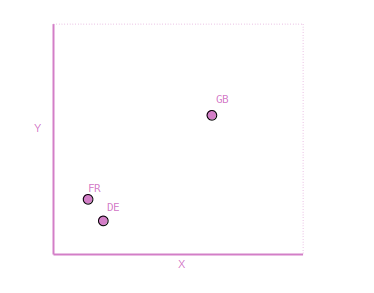

The exact meaning of the positions does not need to make sense to humans, it sometimes does, but really only needs to make sense to the model.

### Second Model

Let try the example as previously, but this time encode the country and MCC as an **integer** rather than a OneHot Encoded vector. We use a `FeatureIndex` instead of a FeatureOneHot.

In [11]:
mcc_i = ft.FeatureIndex('MCC_I', ft.FEATURE_TYPE_INT_16, mcc)
country_i = ft.FeatureIndex('Country_I', ft.FEATURE_TYPE_INT_16, country)

td_i = ft.TensorDefinition('Features_I', [mcc_i, country_i])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_i, td_amount, td_label), file, inference=False)

# Split, again just for giggles
train, val, test = ti.split_sequential(2,1)

# Creating DataSets from our NumpyInstance
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

2023-04-02 12:06:12.387 eng1n3.common.engine           INFO     Start Engine...
2023-04-02 12:06:12.388 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-02 12:06:12.389 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-02 12:06:12.389 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/intro_card.csv
2023-04-02 12:06:12.395 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-02 12:06:12.396 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


The content of the first list is diferent, we can see that it is of type 'int64' or 'Long', where previously it was a float32. It contains 2 numbers. 

For the first sample in our DataSet, the 2 numbers are '1' and '1'. Those correspond to the index of 'MCC 0001' and 'Country DE'.

In [12]:
train_ds[0], train_ds[0][0].shape, train_ds[0][0].dtype

((tensor([1, 1]), tensor([1.]), tensor([0.])), torch.Size([2]), torch.int64)

In [13]:
mcc_i.dictionary['0001'], country_i.dictionary['DE']

(1, 1)

Below we create a second model. It's almost exactly the same as the first model with the exception of the `create_heads` method call. Here we provide 4 extra parameters:
- **dim_ratio (float)**: Determines the size of the embedding. The size of the embedding is `element_count * dim_ratio`.
- **min_dims (int)**: If the embedding size as calcuated per above is smaller than min_dim, then use min_dim as size
- **min_dims (int)**: If the embedding size as calcuated per above is bigger than max_dim, then use max_dim as size.
- **dropout (float)**: A dropout ratio to apply to the combined embedding output.

In the output we can see that the header layer looks differently. We still have 2 heads. The second head is the amount, the first one is the head for the 'FeatureIndex' features. It contains an Embedding for each feature. 
- The **first** Embedding has a size (5x2). 5 is the number of entries (our 4 MCC codes) + 1 (for unknown). 2 is the size of each embedding. that is 5x 0.5 (the dim_ratio), rounded down.
- The **second** Embedding has a size (4x2). 5 is the number of entries (our 3 Countries) + 1. 2 is the (4 * 0.5). If there would have been 2 entries, then the size would still have been 2, the *min_dim* would have kicked in.

An embedding layer will forward through each embedding and then concatenate the ouput. That output will be of size *'sum of the embedding dimensions'* In our case 2 for the MCC Embedding + 2 for the Country Embedding.

After the concatenation this model applies a **dropout** layer with a percentage of 0.1, this layer will randomly change 10% of the node outputs to 0, that introduces a bit of randomness and generally speaking helps the model generalize better.

The Linear Layer has an input size of 5 after concatenation of all the heads. That is 2 (size of MCC embedding) + 2 (size of Country Embedding) + 1 for the amount.

In [14]:
class SecondModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        super(SecondModel, self).__init__(tensor_instance)
        self.heads = self.create_heads(dim_ratio=0.6, min_dims=2, max_dims=5, dropout=0.1)
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        self.tail = self.create_tail()

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)
    
model = SecondModel(train)
model

SecondModel(
  Number of parameters : 24. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=Features_I, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(5, 2)
          (1): Embedding(4, 2)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=5, out_features=1, bias=True)
  (tail): Sigmoid()
)

#### Plotting the Embedding
In order to sort of get a feel for the embeddings, we can try to plot them. (Ours conviently have 2 dimensions, so they are something our brains can understand). Let's try for the MCC Index Feature.

The weights can be accessed and converted to numpy. That numpy array has a size 5x2. As we mentioned previously each row is an MCC code, the 0th row is the unknown element. And each row has 2 entries, because that is the dimensions of the embedding. 

In [15]:
mcc_weights = model.heads[0].embedding.embedding_weight(mcc_i).detach().numpy()
mcc_weights.shape, mcc_weights

((5, 2),
 array([[ 0.79398227, -0.7142445 ],
        [ 0.06384993, -1.186797  ],
        [ 0.14305125, -0.10017417],
        [ 0.81404525,  1.0633466 ],
        [-0.33743072, -0.10665843]], dtype=float32))

We can plot these numpy arrays in a scatter plot using `matplotlib`

Text(0, 0.5, 'Y')

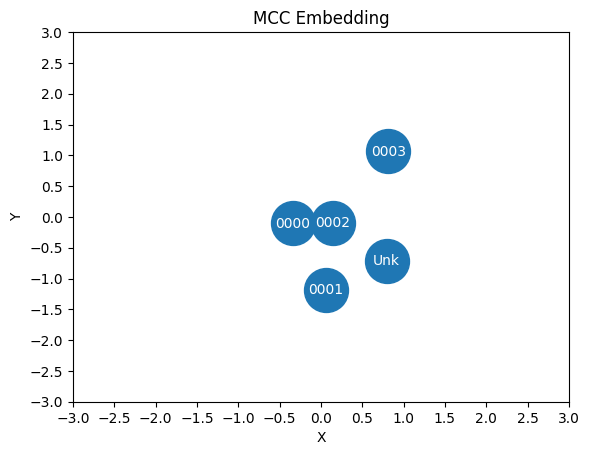

In [16]:
x, y = mcc_weights[:, 0], mcc_weights[:, 1]

ticks = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

plt.title('MCC Embedding')
plt.scatter(x, y, s=1000)
plt.xticks(ticks)
plt.yticks(ticks)
for l,i in [('Unk', 0)] + sorted(list(mcc_i.dictionary.items()), key= lambda x: x[1]):
    plt.text(x[i], y[i], l, ha='center', va='center', color='white')
plt.xlabel('X')
plt.ylabel('Y')

Note that at present, the entries are just randomly mapped, the model has not been trained so this plot means nothing. But as the model is trained, it will shift the x and y coordinates of each of the elements so their relative position is useful for solving the problem at hand.

Say for instance that MCC codes **0001** and **0003** are used regulary at the same Merchants and broadly speaking have the same amount, the model **might** decide that it is interesting to have them close together.

Text(0, 0.5, 'Y')

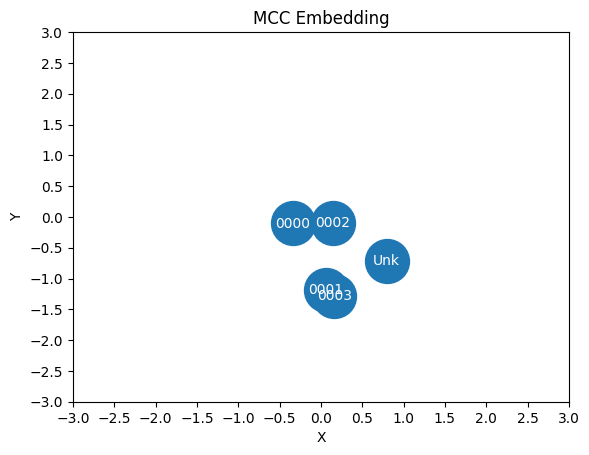

In [17]:
x[mcc_i.dictionary['0003']] = x[mcc_i.dictionary['0001']] + 0.10
y[mcc_i.dictionary['0003']] = y[mcc_i.dictionary['0001']] - 0.10

ticks = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

plt.title('MCC Embedding')
plt.scatter(x, y, s=1000)
plt.xticks(ticks)
plt.yticks(ticks)
for l,i in [('Unk', 0)] + sorted(list(mcc_i.dictionary.items()), key= lambda x: x[1]):
    plt.text(x[i], y[i], l, ha='center', va='center', color='white')
plt.xlabel('X')
plt.ylabel('Y')

### Loss

During training we will try to optimize (i.e. reduce) a loss. The loss is a number that indicates how good the predictions are that were made by the model. Training is an iterative process where we aim to reduce the loss. 

The specific loss function we use depends on how and what we are predicting, for instance regression vs classification, multi-class vs single-class etc... 

Luckily our 'model' knows which function to use. We are doing **a single label, single class classification** problem, so it knows it's probably best to use **BinaryCrossEntropy**.

In [18]:
l_fn = model.loss_fn
l_fn

SingleLabelBCELoss,  mean

#### Getting rid  of Randomness

If we were to process the same record through our second model repeatedly, we would find that we get a **different result** each time. The ouput would be more or less random, strange! The reason we have this randomness is the `dropout` layer in the header, it randomly replaces 10% of the combined Embedding ouput by 0. We did this so the model generalizes better, but it also make our output feel random. There are various things we could do to fix this.

1. We could revert back to one-hot encoded input, there was no associated drop-out in the header for those, we only apply dropout to the 'Embedding' features.

2. We could specify a dropout of 0. The the header layer would omit the dropout layer.

3. We can put the model in 'evaluation' mode. In 'evaluation' mode PyTorch gets rid of some training specifics, not only for the drop-out, but for other layers also.

In inference mode, we should **always** be putting the model in `evaluation` mode, let's get into the good habit of doing so;

In [19]:
model.eval()

SecondModel(
  Number of parameters : 24. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=Features_I, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(5, 2)
          (1): Embedding(4, 2)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=5, out_features=1, bias=True)
  (tail): Sigmoid()
)

We can now calculate the predicted y **(y_pred)** and fetch the actual y (the fraud label). Like is the case for the 'x'-es, the model knows how to get the 'y'-s from the input DataSet. (It does so by index, the index of the TensorDefinition with the `FeatureLabel` to be more specific)

In [20]:
# This is the actual label 
y = model.get_y(train_ds[0])

# This is what our UNTRAINED model predicts
inp = tuple(t.unsqueeze(dim=0) for t in model.get_x(train_ds[0]))
y_pred = model(inp)

print(f'y={y[0].item()}, y_pred={y_pred[0].item()}')

y=0.0, y_pred=0.23128648102283478


Once we have those we can determine the loss, i.e. the measure we use in Neural Nets to quantify how `accurate` the model predictions are. When we train a model, the objective will be to reduce this loss, so that the predicted 'y'-s get closer to the actual y label.

In [21]:
l_fn(y_pred, y)

tensor(0.2630, grad_fn=<BinaryCrossEntropyBackward0>)

## Conclusion

We created a first very simple model, saw how it can make a prediction and how we measure how good that prediction is. Next up, we start training the model.